In [1]:
#https://pjreddie.com/projects/mnist-in-csv/
!wget https://pjreddie.com/media/files/mnist_train.csv
!wget https://pjreddie.com/media/files/mnist_test.csv

--2023-01-26 05:41:12--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [application/octet-stream]
Saving to: ‘mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  34.4MB/s    in 3.0s    

2023-01-26 05:41:16 (34.4 MB/s) - ‘mnist_train.csv’ saved [109575994/109575994]

--2023-01-26 05:41:16--  https://pjreddie.com/media/files/mnist_test.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M  20.9MB/s    in 0.8s    

2023-01-26 05:41:17 (20.9 MB/s) - ‘mnist_test.csv’ saved [18289443/18289443]



In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class MNISTDataset(Dataset):
  def __init__(self,fname):
    self.data = np.loadtxt(
        fname = fname,
        dtype = np.float32,
        delimiter=','
    )

  def getdata(self):
    return self.data
  
  def __getitem__(self,index):
    x1 = np.array(self.data[index,1:],dtype = np.float32)
    x2 = torch.tensor(cv2.copyMakeBorder(x1.reshape(28,28),2,2,2,2,borderType = cv2.BORDER_CONSTANT),dtype = torch.float32)
    x = x2.reshape(1,32,32)

    y = torch.tensor(self.data[index,0],dtype = torch.int64)

    return x,y

  def __len__(self):
    return len(self.data)

In [4]:
train_data = MNISTDataset('/content/mnist_train.csv')
test_data = MNISTDataset('/content/mnist_test.csv')

In [5]:
img,label = test_data[0]
img.shape

<ipython-input-3-5bab91fdc8db>:17: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.data[index,0],dtype = torch.int64)


torch.Size([1, 32, 32])

In [6]:
x1 = np.ones((28,28),dtype = np.float32)
x2 = torch.tensor(np.pad(x1,pad_width=2,mode = 'constant',constant_values = 0),dtype = torch.float32)
x = x2.reshape((1,32,32))
x.shape

torch.Size([1, 32, 32])

<ipython-input-3-5bab91fdc8db>:17: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.data[index,0],dtype = torch.int64)


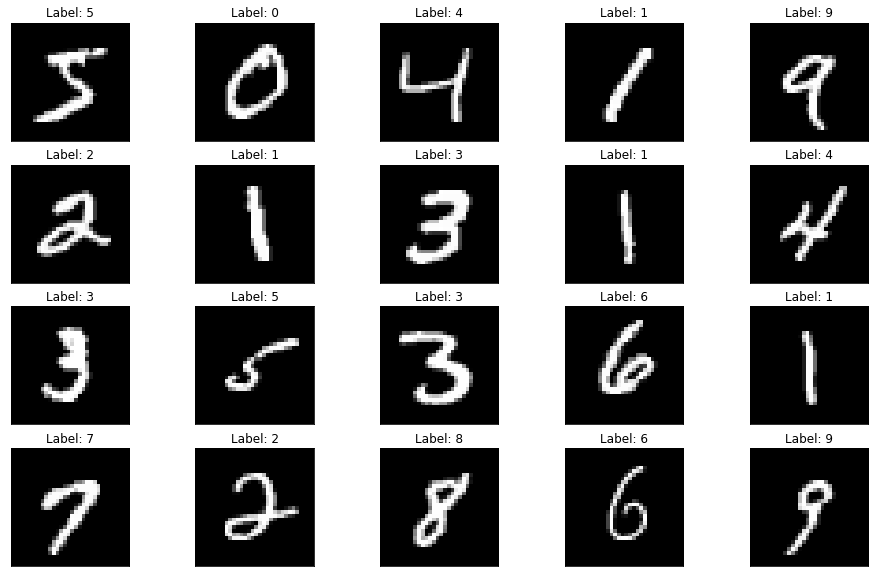

In [7]:
plt.figure(figsize=(16,10))
for i in range(20):
  plt.subplot(4,5,i+1)
  img,label = train_data[i]
  plt.imshow(img.reshape(32,32),cmap = plt.get_cmap('gray'))
  plt.title(f'Label: {label}')
  plt.xticks([])
  plt.yticks([])
plt.show()

In [8]:
train_loader = DataLoader(dataset = train_data,batch_size=1200)
test_loader = DataLoader(dataset = test_data,batch_size=1200)

In [9]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84, 10)
    self.tanh = nn.Tanh()
    self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv3(x)
    x = self.tanh(x)
    
    x = x.reshape(x.shape[0], -1)
    x = self.linear1(x)
    x = self.tanh(x)
    x = self.linear2(x)
    return x

In [10]:
model = LeNet()

In [11]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [12]:
num_epochs = 10
total_step = len(train_loader)
for epoch in range(num_epochs):
  loss_list = []
  total_loss = 0
  for i ,(train_x,train_y) in enumerate(train_loader):
    output = model(train_x)
    loss = criterion(output,train_y)
    total_loss += loss
    loss_list.append(loss)

    # backward
    loss.backward()

    # update
    optimizer.step()

    optimizer.zero_grad()
  print(f'Epoch:[{epoch+1}/{num_epochs}] Step:[{i+1}/{total_step}] Loss:[{(total_loss/total_step).item():.6f}]')


<ipython-input-3-5bab91fdc8db>:17: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.data[index,0],dtype = torch.int64)


Epoch:[1/10] Step:[50/50] Loss:[1.061936]
Epoch:[2/10] Step:[50/50] Loss:[0.296574]
Epoch:[3/10] Step:[50/50] Loss:[0.158865]
Epoch:[4/10] Step:[50/50] Loss:[0.106091]
Epoch:[5/10] Step:[50/50] Loss:[0.082816]
Epoch:[6/10] Step:[50/50] Loss:[0.068884]
Epoch:[7/10] Step:[50/50] Loss:[0.059091]
Epoch:[8/10] Step:[50/50] Loss:[0.052187]
Epoch:[9/10] Step:[50/50] Loss:[0.046806]
Epoch:[10/10] Step:[50/50] Loss:[0.042022]


In [13]:
img,label = next(iter(test_loader))
pred = model(img)
pred_1 = torch.argmax(pred,dim = 1)

<ipython-input-3-5bab91fdc8db>:17: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.data[index,0],dtype = torch.int64)


In [14]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(pred_1,label)
conf_mat

array([[100,   0,   0,   0,   0,   0,   3,   0,   1,   0],
       [  0, 146,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0, 133,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1, 125,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0, 135,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0, 107,   2,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0, 100,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0, 121,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0, 104,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   1, 113]])

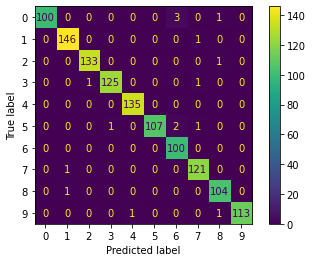

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix = conf_mat)
display.plot()
plt.show()

In [16]:
from sklearn.metrics import accuracy_score
accurancy = accuracy_score(label,pred_1)
accurancy

0.9866666666666667

In [17]:
pred_idx = pred_1[pred_1 != label]
print(pred_idx)
print(len(pred_idx))

tensor([5, 0, 0, 0, 2, 3, 8, 3, 7, 5, 9, 9, 0, 5, 1, 5])
16


In [18]:
label_idx = label[pred_1 != label]
print(label_idx)
print(len(label_idx))

tensor([3, 6, 6, 8, 8, 2, 1, 7, 1, 7, 4, 8, 6, 6, 7, 6])
16


In [20]:
lst = []
for i in range(len(label)):
  if label[i] != pred_1[i]:
    lst.append(i)
print(lst)
len(lst)

[18, 259, 445, 495, 582, 583, 619, 684, 716, 726, 740, 947, 965, 1014, 1039, 1182]


16

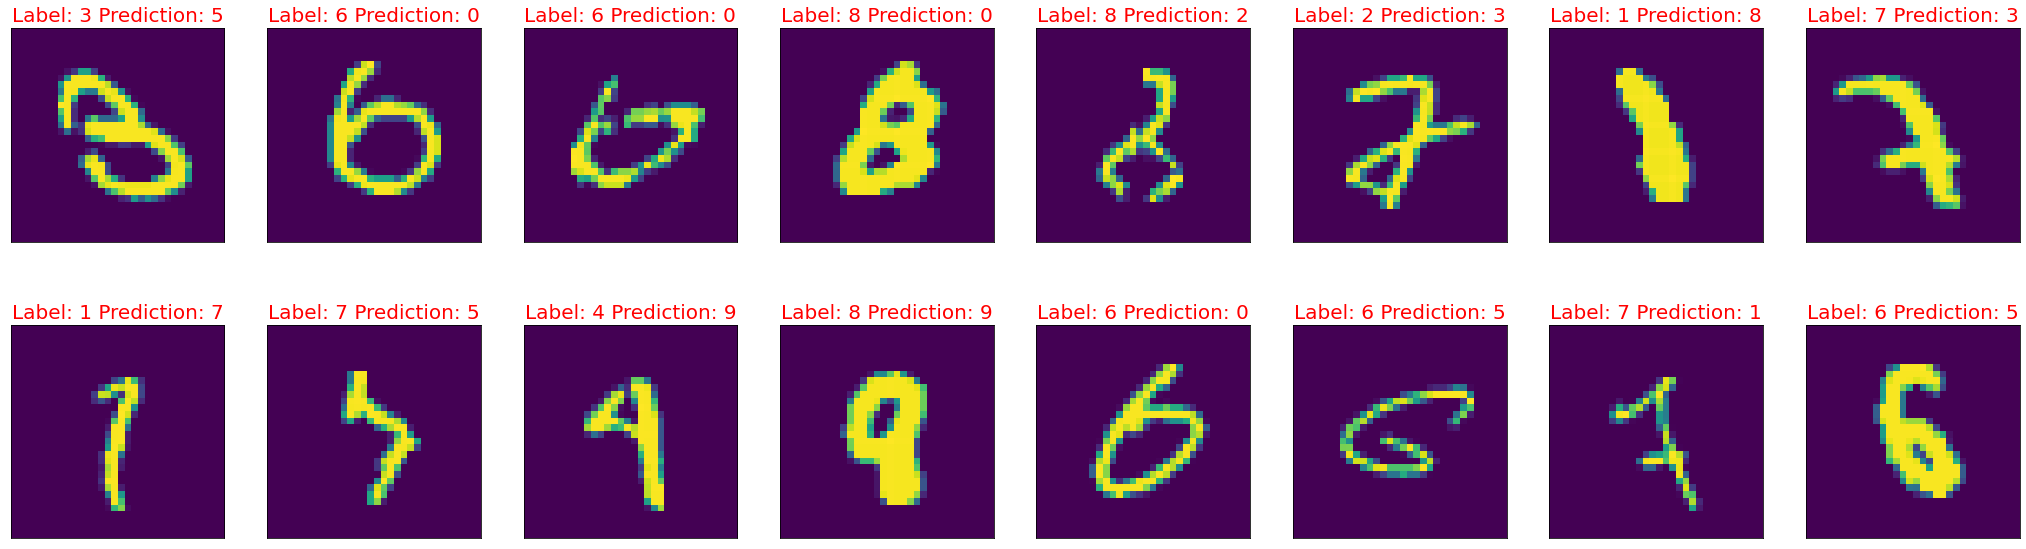

In [30]:
plt.figure(figsize = (36,10))
for i in range(len(lst)):
  plt.subplot(2,len(lst)//2,i+1)
  plt.imshow(img[lst[i]].reshape(32,32))
  plt.title(f'Label: {label_idx[i]} Prediction: {pred_idx[i]}',color = 'r',size = 20 )
  plt.xticks([])
  plt.yticks([])
plt.show()